# My First Convolutional Neural Network

## Fashion MNIST

#### 실습목표<br>
1. CNN의 기본 아이디어를 안다.
2. CNN의 구조를 그리고, 코드로 옮길 수 있다.

## Real Game : CNN on Fashion MNIST

여기에서는 여러분이 직접 코드를 완성해야 하는 문제가 곳곳에 있습니다!

In [21]:
'''
matplolib inline 명령어를 통해서
matplot으로 그리는 플롯들을 주피터 노트북 내에서 볼 수 있게 해준다.
포맷을 retina로 바꾸면 그래프의 화질이 훨씬 좋아진다.
'''
% matplotlib inline
% config InlineBackend.figure_format = 'retina'

'''
라이브러리들을 불러오자.
'''
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, BatchNormalization, Activation, Dropout
from tensorflow.keras import layers, models
from tensorflow.keras import backend

import random as rd
from sklearn.metrics import accuracy_score

### Data Loading

In [22]:
(train_x, train_y), (test_x, test_y) = tf.keras.datasets.fashion_mnist.load_data()

In [23]:
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


In [24]:
labels = ["T-shirt/top",  # index 0
          "Trouser",  # index 1
          "Pullover",  # index 2
          "Dress",  # index 3
          "Coat",  # index 4
          "Sandal",  # index 5
          "Shirt",  # index 6
          "Sneaker",  # index 7
          "Bag",  # index 8
          "Ankle boot"]  # index 9

print(labels)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


id = 181
다음 그림은 Ankle boot 입니다.


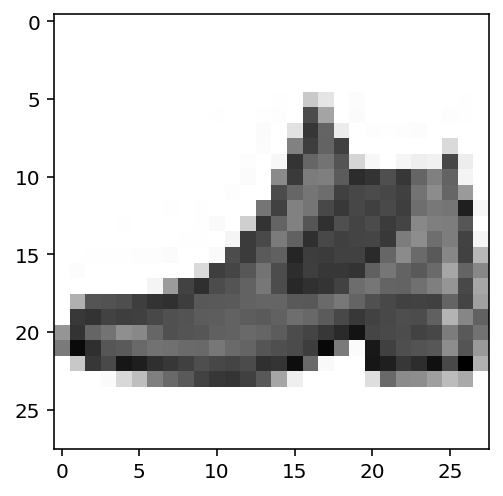

In [25]:
'''
Ctrl+Enter를 이용하여
반복 실행 해보자!
'''

id = rd.randrange(0, 10000)

print(f'id = {id}')
print(f'다음 그림은 {labels[test_y[id]]} 입니다.')
plt.imshow(test_x[id], cmap='Greys')
plt.show()

### X : Min-Max Scaling

1. 최소값 0, 최대값 1로 통일하는 스케일링

In [26]:
from sklearn.preprocessing import MinMaxScaler

In [27]:
scaler = MinMaxScaler()

train_x = train_x / 255
test_x = test_x / 255

### X : Reshape(# of data, 28, 28, 1)

**끝에 1을 달아서 그레이스케일(흑백)을 명시해준다.**

In [28]:
train_x = train_x.reshape(-1, 28, 28, 1)
test_x = test_x.reshape(-1, 28, 28, 1)

### Y : One-Hot Encoding

In [30]:
from keras.utils import to_categorical

In [33]:
n_class = len(np.unique(train_y))
n_class

10

In [34]:
train_y = to_categorical(train_y, n_class)
test_y = to_categorical(test_y, n_class)

### 코드를 완성해주세요!

**자유롭게 먼저 해보는 것을 추천**




**구조를 따라서 코딩을 한다면..**

1. 인풋레이어
1. Convolution : 필터수 32개, 사이즈(3, 3), same padding
2. BatchNormalization
2. Convolution : 필터수 32개, 사이즈(3, 3), same padding
3. BatchNormalization
4. MaxPooling : 사이즈(2,2) 스트라이드(2,2)
5. DropOut : 25% 비활성화
1. Convolution : 필터수 64개, 사이즈(3, 3), same padding
3. BatchNormalization
2. Convolution : 필터수 64개, 사이즈(3, 3), same padding
3. BatchNormalization
4. MaxPooling : 사이즈(2,2) 스트라이드(2,2)
5. DropOut : 25% 비활성화
6. Flatten()
7. Fully Connected Layer : 노드 512개
3. BatchNormalization
9. 아웃풋레이어

In [35]:
from keras.layers import *
from keras.callbacks import *

In [36]:
# clear session
keras.backend.clear_session()

# 모델 선언
model = keras.models.Sequential()

model.add(Input(shape=train_x.shape[1:]))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), (2, 2)))
model.add(BatchNormalization())
model.add(Dropout(.25))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), (2, 2)))
model.add(Dropout(.25))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(n_class, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy, optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0

### Early Stopping을 활용한 학습

1. validation_split = 0.2
2. 1 epochs만 관찰해가며 속도가 가장 빠른 batch_size 찾아보기. 128개부터 시작하여 조절해볼 것.
3. EarlyStopping. val_loss가 4 epoch 전과 비교하여 개선되지 않으면 스탑


In [37]:
es = EarlyStopping(monitor='val_loss',
                   min_delta=0,
                   patience=5,
                   verbose=1,
                   restore_best_weights=True)

mcp = ModelCheckpoint(filepath='./content/CNN_Fashion.ckpt',
                      monitor='val_loss',
                      save_best_only=True,
                      save_weights_only=True,
                      verbose=1)

In [38]:
model.fit(train_x, train_y, verbose=1, validation_split=.2, epochs=128, callbacks=[es, mcp])

Epoch 1/128
1495/1500 [============================>.] - ETA: 0s - loss: 2.3034 - accuracy: 0.0995
Epoch 00001: val_loss improved from inf to 2.30395, saving model to ./contetn\CNN_Fashion.ckpt
1500/1500 [==============================] - 4s 2ms/step - loss: 2.3034 - accuracy: 0.0996 - val_loss: 2.3039 - val_accuracy: 0.1005
Epoch 2/128
1496/1500 [============================>.] - ETA: 0s - loss: 2.3032 - accuracy: 0.0950
Epoch 00002: val_loss improved from 2.30395 to 2.30294, saving model to ./contetn\CNN_Fashion.ckpt
1500/1500 [==============================] - 3s 2ms/step - loss: 2.3032 - accuracy: 0.0950 - val_loss: 2.3029 - val_accuracy: 0.0957
Epoch 3/128
1478/1500 [============================>.] - ETA: 0s - loss: 2.3030 - accuracy: 0.0987
Epoch 00003: val_loss did not improve from 2.30294
1500/1500 [==============================] - 3s 2ms/step - loss: 2.3030 - accuracy: 0.0989 - val_loss: 2.3038 - val_accuracy: 0.0957
Epoch 4/128
1473/1500 [============================>.] - ET

In [39]:
model.evaluate(test_x, test_y)

313/313 [==============================] - 0s 1ms/step - loss: 2.3027 - accuracy: 0.1000


[2.3027243614196777, 0.10000000149011612]